## Imports

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels as sm
import warnings

In [3]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import brier_score_loss, mean_squared_error, r2_score
from sklearn.decomposition import PCA

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [5]:
from sklearn.linear_model import Lasso

In [6]:
# models

In [7]:
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor

## Appendix A: Functions

In [8]:
# This function was modified from a contributors work on stackoverflow
# https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python
# Author - tmthydvnprt


def best_fit_distribution(data, bins=10, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [
            st.alpha,st.arcsine,st.beta,st.betaprime,st.chi,st.chi2,
            st.dgamma,st.dweibull,st.exponnorm,st.exponweib,
            st.gausshyper,st.gamma,
            st.halfnorm,st.invgamma,st.invgauss,
            st.laplace,
            st.logistic,st.loggamma,st.lognorm,
            st.norm,st.powerlognorm,st.powernorm,
            st.recipinvgauss,st.t,st.triang,
            st.uniform,st.weibull_min,st.weibull_max
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

In [9]:
def ord_brier(forecast,actual):
    #find squared error of each cumulative group of bins
    bin1cum=(sum(forecast[:1])-sum(actual[:1]))**2
    bin2cum=(sum(forecast[:2])-sum(actual[:2]))**2
    bin3cum=(sum(forecast[:3])-sum(actual[:3]))**2
    bin4cum=(sum(forecast[:4])-sum(actual[:4]))**2
    #bin5cumulativeerror will always be 0
    
    totalerror = bin1cum + bin2cum + bin3cum +bin4cum
    score = totalerror/4
    return(score)

In [10]:
def calculate_brier(X, y, X_pred,y_pred, model):

    model.fit(X,y)
    
    # Pull rows for each country to be predicted
    X_SSD_1807 = X_pred[3:4] # Select SSD Data for July to predict August
    X_CAF_1807 = X_pred[2:3] # Select ETH Data for July to predict August
    X_ETH_1807 = X_pred[1:2]  # Select ETH Data for July to predict August
    X_COD_1807 = X_pred[0:1]  # Select ETH Data for July to predict August

    # Find the best fitting distribution
    error = y - model.predict(X)
    best, params = best_fit_distribution(error, bins=20)
    best_dist = best(*params)
    
    # Find Ethiopia's predicted bin values
    ETH_pred = model.predict(X_ETH_1807)
    b1 = best_dist.cdf(33 - ETH_pred)
    b2 = best_dist.cdf(50 - ETH_pred) - b1
    b3 = best_dist.cdf(70 - ETH_pred) - (b1+b2)
    b4 = best_dist.cdf(105 - ETH_pred) - (b1+b2+b3)
    b5 = 1 - (b1+b2+b3+b4)

    pred_list1 = np.array([b1,b2,b3,b4,b5])
    actual_list = np.array([1,0,0,0,0])

    b_ETH = ord_brier(pred_list1,actual_list)

    SSD_pred = model.predict(X_SSD_1807)
    b1 = best_dist.cdf(80 - SSD_pred)
    b2 = best_dist.cdf(130 - SSD_pred) - b1
    b3 = best_dist.cdf(210 - SSD_pred) - (b1+b2)
    b4 = best_dist.cdf(310 - SSD_pred) - (b1+b2+b3)
    b5 = 1 - (b1+b2+b3+b4)

    pred_list2 = np.array([b1,b2,b3,b4,b5])
    actual_list = np.array([1,0,0,0,0])

    b_SSD = ord_brier(pred_list2,actual_list)

    CAF_pred = model.predict(X_CAF_1807)
    b1 = best_dist.cdf(10 - CAF_pred)
    b2 = best_dist.cdf(30 - CAF_pred) - b1
    b3 = best_dist.cdf(50 - CAF_pred) - (b1+b2)
    b4 = best_dist.cdf(100 - CAF_pred) - (b1+b2+b3)
    b5 = 1 - (b1+b2+b3+b4)

    pred_list3 = np.array([b1,b2,b3,b4,b5])
    actual_list = np.array([0,0,1,0,0])

    b_CAF = ord_brier(pred_list3,actual_list)

    COD_pred = model.predict(X_COD_1807)
    b1 = best_dist.cdf(51 - COD_pred)
    b2 = best_dist.cdf(69 - COD_pred) - b1
    b3 = best_dist.cdf(91 - COD_pred) - (b1+b2)
    b4 = best_dist.cdf(129 - COD_pred) - (b1+b2+b3)
    b5 = 1 - (b1+b2+b3+b4)

    pred_list4 = np.array([b1,b2,b3,b4,b5])
    actual_list = np.array([1,0,0,0,0])

    b_COD = ord_brier(pred_list4,actual_list)

    return(b_ETH, b_SSD, b_CAF, b_COD, best.name)

In [11]:
def calculate_brier_ind(X, y, X_pred,y_pred, model, country):

    model.fit(X,y)
    
    X_SSD_1807 = X_pred # Select SSD Data for July to predict August
    X_CAF_1807 = X_pred # Select ETH Data for July to predict August
    X_ETH_1807 = X_pred  # Select ETH Data for July to predict August
    X_COD_1807 = X_pred  # Select ETH Data for July to predict August

    error = y - model.predict(X)
    best, params = best_fit_distribution(error, bins=30)
    best_dist = best(*params)

    if country == 'ETH':
        ETH_pred = model.predict(X_ETH_1807)
        b1 = best_dist.cdf(33 - ETH_pred)
        b2 = best_dist.cdf(50 - ETH_pred) - b1
        b3 = best_dist.cdf(70 - ETH_pred) - (b1+b2)
        b4 = best_dist.cdf(105 - ETH_pred) - (b1+b2+b3)
        b5 = 1 - (b1+b2+b3+b4)

        pred_list1 = np.array([b1,b2,b3,b4,b5])
        actual_list = np.array([1,0,0,0,0])

        b = ord_brier(pred_list1,actual_list)

    if country == 'SSD':
        SSD_pred = model.predict(X_SSD_1807)
        b1 = best_dist.cdf(80 - SSD_pred)
        b2 = best_dist.cdf(130 - SSD_pred) - b1
        b3 = best_dist.cdf(210 - SSD_pred) - (b1+b2)
        b4 = best_dist.cdf(310 - SSD_pred) - (b1+b2+b3)
        b5 = 1 - (b1+b2+b3+b4)

        pred_list2 = np.array([b1,b2,b3,b4,b5])
        actual_list = np.array([1,0,0,0,0])

        b = ord_brier(pred_list2,actual_list)

    if country == 'CAF':
        CAF_pred = model.predict(X_CAF_1807)
        b1 = best_dist.cdf(10 - CAF_pred)
        b2 = best_dist.cdf(30 - CAF_pred) - b1
        b3 = best_dist.cdf(50 - CAF_pred) - (b1+b2)
        b4 = best_dist.cdf(100 - CAF_pred) - (b1+b2+b3)
        b5 = 1 - (b1+b2+b3+b4)

        pred_list3 = np.array([b1,b2,b3,b4,b5])
        actual_list = np.array([0,0,1,0,0])

        b = ord_brier(pred_list3,actual_list)

    if country == 'COD':
        COD_pred = model.predict(X_COD_1807)
        b1 = best_dist.cdf(51 - COD_pred)
        b2 = best_dist.cdf(69 - COD_pred) - b1
        b3 = best_dist.cdf(91 - COD_pred) - (b1+b2)
        b4 = best_dist.cdf(129 - COD_pred) - (b1+b2+b3)
        b5 = 1 - (b1+b2+b3+b4)

        pred_list4 = np.array([b1,b2,b3,b4,b5])
        actual_list = np.array([1,0,0,0,0])

        b = ord_brier(pred_list4,actual_list)

    return(b, best.name)

# Team Blue Model Analysis

## Modeling

### All Countries

In [12]:
df = pd.read_csv('battle_data.csv')
df2 = df.drop(columns = ['Year/Month', 'Unnamed: 0'])
df3 = pd.get_dummies(df2, columns = ['Country_Code', 'month'])
df3['lag_fatal_1'] = df3['fatalities'].shift(4) # Add three month lag - Found in Tuning Notebook
df3['lag_fatal_2'] = df3['fatalities'].shift(8) # Add three month lag - Found in Tuning Notebook
df3['lag_fatal_3'] = df3['fatalities'].shift(12) # Add three month lag - Found in Tuning Notebook
df3.lag_fatal_1[0:4] = [68,0,15,47] # Add missing values (33,0,97,172,52,0,6,73,) <-- Add to front for more months
df3.lag_fatal_2[0:8] = [52,0,6,73,68,0,15,47]
df3.lag_fatal_3[0:12] = [33,0,97,172,52,0,6,73,68,0,15,47]

X = df3.drop(columns = 'fatalities')
y = df3.fatalities
#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.1, random_state=0)
X_train = X[:-60]
X_test = X[-60:]
y_train = y[:-60]
y_test = y[-60:]

X_pred = X[-60:-56]
y_pred = y[-60:-56]

C:\Users\ssq10\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\ssq10\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\ssq10\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [13]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_pred = scaler.transform(X_pred)
X2 = scaler.fit_transform(X)

In [14]:
#pca = PCA(0.50).fit(X2)
#pca.n_components_

In [15]:
#components = pca.transform(X2)
#X2 = pca.inverse_transform(components)

In [16]:
#components_pred = pca.transform(X_pred2)
#X_pred2 = pca.inverse_transform(components_pred)

In [17]:
models = []
models.append(('RF',RandomForestRegressor(n_estimators = 80,max_features = 10, max_depth = 6,random_state=0))) #mf10
models.append(('Ada', AdaBoostRegressor(n_estimators=100, learning_rate=.05,random_state=0)))
models.append(('XGB',XGBRegressor(n_estimators=30, learning_rate=.06,random_state=0,objective ='reg:squarederror')))
models.append(('Tree',DecisionTreeRegressor(max_depth=5,max_features=10,random_state=0)))
models.append(('Ridge',Ridge(alpha=24.77,random_state=0)))
models.append(('Lasso',Lasso(alpha=8.11,random_state=0)))
models.append(('SVR', SVR(kernel='rbf',gamma=.09)))
models.append(('NB', BayesianRidge(alpha_1=.01,alpha_2=100)))

## Fit and Compare

In [18]:
names = []
results = []
means = []
sdevs = []
r_square = []

pred_ETH = []
act_ETH = []
bs_ETH = []
pred_SSD = []
act_SSD = []
bs_SSD = []
pred_CAF = []
act_CAF = []
bs_CAF = []
pred_COD = []
act_COD = []
bs_COD = []
dist_list = []
scoring = 'neg_mean_squared_error'

In [19]:
for name, model in models:
    
    model.fit(X_train,y_train)
    kfold = KFold(n_splits = 10, random_state=42)
    cv_results = cross_val_score(model,X2,y, cv=kfold, scoring=scoring)
    results.append(-cv_results)
    means.append(-cv_results.mean()) # mean_squared_error(y_test, model.predict(X_test))
    #sdevs.append(cv_results.std())
    
    r_square.append(cross_val_score(model,X2,y, cv=kfold, scoring='r2').mean()) # r2_score(y_test,model.predict(X_test))
    b_ETH,b_SSD,b_CAF,b_COD, best_dist = calculate_brier(X_train,y_train,X_pred,y_pred,model)
    dist_list.append(best_dist)
    
    X_SSD_1807 = X_pred[3:4] # Select SSD Data for July to predict August
    pred_SSD.append(model.predict(X_SSD_1807)[0])
    act_SSD.append(y_pred.values[3])
    X_CAF_1807 = X_pred[2:3] # Select ETH Data for July to predict August
    pred_CAF.append(model.predict(X_CAF_1807)[0])
    act_CAF.append(y_pred.values[2])
    X_ETH_1807 = X_pred[1:2]  # Select ETH Data for July to predict August
    pred_ETH.append(model.predict(X_ETH_1807)[0])
    act_ETH.append(y_pred.values[1])    
    X_COD_1807 = X_pred[0:1]  # Select ETH Data for July to predict August
    pred_COD.append(model.predict(X_COD_1807)[0])
    act_COD.append(y_pred.values[0])
    
    bs_ETH.append(b_ETH[0])
    bs_SSD.append(b_SSD[0])
    bs_CAF.append(b_CAF[0])
    bs_COD.append(b_COD[0])
    names.append(name);

C:\Users\ssq10\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ssq10\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
C:\Users\ssq10\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ssq10\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ssq10\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ssq

In [20]:
# random_state ensures that same splits on all models

In [21]:
mean_squared_error(y_test,[y_train.mean()]*len(y_test)) # Number to Beat!

6908.264195419394

In [22]:
df1 = pd.DataFrame()
df1['Model'] = names
df1['MSE'] = means
#df1['MSE Std Dev'] = sdevs
df1['R^2'] = r_square
df1['Brier Dist'] = dist_list
df1['Brier CAF'] = bs_CAF
df1['Brier COD'] = bs_COD
df1['Brier ETH'] = bs_ETH
df1['Brier SSD'] = bs_SSD
df1


,Model,MSE,R^2,Brier Dist,Brier CAF,Brier COD,Brier ETH,Brier SSD
0,RF,6344.424574,0.194006,exponweib,0.146912,0.307751,0.521351,0.454980
1,Ada,6452.808832,0.214721,alpha,0.141570,0.244359,0.252970,0.397781
2,XGB,6850.908235,0.196834,gamma,0.131064,0.238468,0.288052,0.437081
3,Tree,9670.001076,-0.267918,exponnorm,0.094169,0.103447,0.566588,0.548520
4,Ridge,6512.153255,0.145782,exponnorm,0.134027,0.111043,0.051785,0.134233
5,Lasso,6365.155980,0.179827,exponnorm,0.126637,0.239424,0.260580,0.311911
6,SVR,9785.614184,-0.195104,invgamma,0.170733,0.277405,0.413040,0.092323
7,NB,6160.908765,0.210215,exponnorm,0.115337,0.158699,0.149103,0.133782


In [23]:
dftest = df1.copy()
dftest = dftest.drop(columns = ['MSE','R^2','Brier Dist'])
dftest['Avg B'] = dftest.mean(axis=1)
dftest

,Model,Brier CAF,Brier COD,Brier ETH,Brier SSD,Avg B
0,RF,0.146912,0.307751,0.521351,0.454980,0.357748
1,Ada,0.141570,0.244359,0.252970,0.397781,0.259170
2,XGB,0.131064,0.238468,0.288052,0.437081,0.273666
3,Tree,0.094169,0.103447,0.566588,0.548520,0.328181
4,Ridge,0.134027,0.111043,0.051785,0.134233,0.107772
5,Lasso,0.126637,0.239424,0.260580,0.311911,0.234638
6,SVR,0.170733,0.277405,0.413040,0.092323,0.238375
7,NB,0.115337,0.158699,0.149103,0.133782,0.139230


In [24]:
df2 = pd.DataFrame()
df2['Model'] = names

df2['Pred Fatalities CAF'] = pred_CAF
df2['Act Fatalities CAF'] = act_CAF
df2['Pred Fatalities COD'] = pred_COD
df2['Act Fatalities COD'] = act_COD
df2['Pred Fatalities ETH'] = pred_ETH
df2['Act Fatalities ETH'] = act_ETH
df2['Pred Fatalities SSD'] = pred_SSD
df2['Act Fatalities SSD'] = act_SSD
df2

,Model,Pred Fatalities CAF,Act Fatalities CAF,Pred Fatalities COD,Act Fatalities COD,Pred Fatalities ETH,Act Fatalities ETH,Pred Fatalities SSD,Act Fatalities SSD
0,RF,77.067174,1,87.352419,140,88.727276,47,175.062235,55
1,Ada,81.015625,1,86.297872,140,68.258065,47,172.615385,55
2,XGB,56.287937,1,63.287483,140,50.479282,47,157.000137,55
3,Tree,55.488372,1,55.488372,140,91.629630,47,209.333333,55
4,Ridge,40.181802,1,60.748756,140,18.878786,47,112.119964,55
5,Lasso,70.996068,1,88.714646,140,72.870074,47,160.237536,55
6,SVR,87.946528,1,88.618211,140,88.945300,47,89.269199,55
7,NB,58.153737,1,74.097113,140,52.862603,47,114.099998,55


In [25]:
# boxplot for comparison

Text(0, 0.5, 'Test MSE')

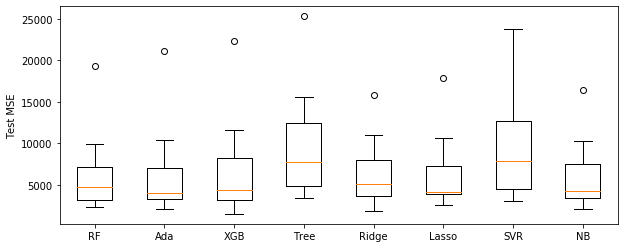

In [26]:
plt.figure(figsize = (10,4))
plt.boxplot(results)
plt.xticks(range(1,9), names)
plt.ylabel('Test MSE')

### Individual Countries

In [27]:
names = []
CAF_results, COD_results, ETH_results, SSD_results = [],[],[],[]
CAF_means, COD_means, ETH_means, SSD_means = [],[],[],[]
CAF_sdevs, COD_sdevs, ETH_sdevs, SSD_sdevs = [],[],[],[]
CAF_r_square, COD_r_square, ETH_r_square, SSD_r_square = [],[],[],[]

pred_ETH, act_ETH, bs_ETH = [], [], []
pred_SSD, act_SSD, bs_SSD = [], [], []
pred_CAF, act_CAF, bs_CAF = [], [], []
pred_COD, act_COD, bs_COD = [], [], []
dist_list = []
cntry_code = ['CAF','COD','ETH','SSD']

CAF_lists = [CAF_results, CAF_means, CAF_sdevs, CAF_r_square, pred_CAF, act_CAF, bs_CAF]
COD_lists = [COD_results, COD_means, COD_sdevs, COD_r_square, pred_COD, act_COD, bs_COD]
ETH_lists = [ETH_results, ETH_means, ETH_sdevs, ETH_r_square, pred_ETH, act_ETH, bs_ETH]
SSD_lists = [SSD_results, SSD_means, SSD_sdevs, SSD_r_square, pred_SSD, act_SSD, bs_SSD]

cntry_lists = [CAF_lists,COD_lists,ETH_lists,SSD_lists]
num2beat = []

scoring = 'neg_mean_squared_error'

In [28]:
for c, c_list in zip(cntry_code,cntry_lists):
    df = pd.read_csv('full_data.csv')
    df2 = df.drop(columns = ['Year/Month', 'Unnamed: 0'])
    df2 = df2[df2['Country_Code'] == c]
    df2 = df2.drop(columns = 'Country_Code')
    df3 = pd.get_dummies(df2, columns = ['month'])
    df3['lag_fatal_1'] = df3['fatalities'].shift(4) # Add three month lag - Found in Tuning Notebook
    df3['lag_fatal_2'] = df3['fatalities'].shift(8) # Add three month lag - Found in Tuning Notebook
    df3['lag_fatal_3'] = df3['fatalities'].shift(12) # Add three month lag - Found in Tuning Notebook
    df3.lag_fatal_1[0:4] = [68,0,15,47] # Add missing values (33,0,97,172,52,0,6,73,) <-- Add to front for more months
    df3.lag_fatal_2[0:8] = [52,0,6,73,68,0,15,47]
    df3.lag_fatal_3[0:12] = [33,0,97,172,52,0,6,73,68,0,15,47]

    X = df3.drop(columns = 'fatalities')
    y = df3.fatalities
    #X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.1, random_state=0)
    X_train = X[:-15]
    X_test = X[-15:]
    y_train = y[:-15]
    y_test = y[-15:]

    X_pred = X[-15:-14]
    y_pred = y[-15:-14]
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_pred2 = scaler.transform(X_pred)
    X2 = scaler.fit_transform(X)
    
    num2beat.append(mean_squared_error(y_test,[y_train.mean()]*len(y_test)))
    
    for name, model in models:
        model.fit(X_train,y_train)
        kfold = KFold(n_splits = 5, random_state=0)
        cv_results = cross_val_score(model,X2,y, cv=kfold, scoring=scoring)
        
        c_list[0].append(-cv_results)
        c_list[1].append(-cv_results.mean()) #mean_squared_error(y_test,model.predict(X_test))
        c_list[2].append(cv_results.std())

        c_list[3].append(cross_val_score(model, X2, y, cv=kfold, scoring ='r2').mean()) # r2_score(y_test,model.predict(X_test))
        b, best_dist = calculate_brier_ind(X_train,y_train,X_pred2,y_pred,model,c)
        dist_list.append(best_dist)

        X_1807 = X_pred2 # Select SSD Data for July to predict August
        c_list[4].append(model.predict(X_1807)[0])
        c_list[5].append(y_pred.values[0])

        c_list[6].append(b[0])

for name, model in models:
    names.append(name);

C:\Users\ssq10\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\ssq10\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\ssq10\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

C:\Users\ssq10\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ssq10\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
C:\Users\ssq10\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ssq10\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ssq10\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ssq

In [29]:
num2beat[0]

4372.244497323022

In [30]:
df_CAF = pd.DataFrame()
df_CAF['Model'] = names
df_CAF['MSE'] = CAF_lists[1]
df_CAF['MSE_Std_Dev'] = CAF_lists[2]
df_CAF['R^2'] = CAF_lists[3]
df_CAF['Pred_Fatalities'] = CAF_lists[4]
df_CAF['Act_Fatalities'] = CAF_lists[5]
df_CAF['Brier_Score'] = CAF_lists[6]
df_CAF

,Model,MSE,MSE_Std_Dev,R^2,Pred_Fatalities,Act_Fatalities,Brier_Score
0,RF,8973.024967,7740.884600,-2.403901,114.329518,28,0.319709
1,Ada,9317.454629,8660.481514,-2.107361,93.545455,28,0.282110
2,XGB,9223.034909,8951.457188,-1.925192,89.862518,28,0.250468
3,Tree,18576.657440,9949.912503,-10.851626,5.000000,28,0.382856
4,Ridge,7382.936362,7219.383059,-1.205373,100.295931,28,0.236685
5,Lasso,8834.227507,8786.558414,-2.034881,103.123439,28,0.250148
6,SVR,9026.839685,11924.741775,-1.144435,76.028656,28,0.135807
7,NB,7951.211254,8095.900216,-1.389977,112.616066,28,0.290403


In [31]:
num2beat[1]

41204.99436843149

In [32]:
df_COD = pd.DataFrame()
df_COD['Model'] = names
df_COD['MSE'] = COD_lists[1]
df_COD['MSE_Std_Dev'] = COD_lists[2]
df_COD['R^2'] = COD_lists[3]
df_COD['Pred_Fatalities'] = COD_lists[4]
df_COD['Act_Fatalities'] = COD_lists[5]
df_COD['Brier_Score'] = COD_lists[6]
df_COD

,Model,MSE,MSE_Std_Dev,R^2,Pred_Fatalities,Act_Fatalities,Brier_Score
0,RF,29618.636358,10488.459968,-0.485773,174.566381,176,0.918201
1,Ada,29763.016667,14365.256900,-0.307838,165.882353,176,0.944194
2,XGB,32120.434149,15871.320148,-0.384502,220.201035,176,1.000000
3,Tree,64743.980950,21858.577677,-2.428438,147.500000,176,0.740030
4,Ridge,30220.214645,11959.792911,-0.534323,214.074998,176,0.898475
5,Lasso,26378.441841,8842.719733,-0.401789,136.486249,176,0.638376
6,SVR,31183.353078,17104.057339,-0.303860,159.000015,176,0.745411
7,NB,34351.650482,13962.577042,-0.681963,215.981339,176,0.912801


In [33]:
num2beat[2]

6652.938687289314

In [34]:
df_ETH = pd.DataFrame()
df_ETH['Model'] = names
df_ETH['MSE'] = ETH_lists[1]
df_ETH['MSE_Std_Dev'] = ETH_lists[2]
df_ETH['R^2'] = ETH_lists[3]
df_ETH['Pred_Fatalities'] = ETH_lists[4]
df_ETH['Act_Fatalities'] = ETH_lists[5]
df_ETH['Brier_Score'] = ETH_lists[6]
df_ETH

,Model,MSE,MSE_Std_Dev,R^2,Pred_Fatalities,Act_Fatalities,Brier_Score
0,RF,12039.011880,8243.976144,-1.656355,135.380528,146,0.872027
1,Ada,11361.857032,9359.832990,-1.022709,141.000000,146,0.928593
2,XGB,12850.848351,10255.457015,-1.279645,94.783745,146,0.781175
3,Tree,33242.314853,14377.588977,-8.960125,102.600000,146,0.556300
4,Ridge,12463.439885,9089.374128,-1.702262,131.805853,146,0.829949
5,Lasso,11825.925237,8637.235714,-1.457513,125.255502,146,0.715404
6,SVR,10567.175854,9443.258919,-0.964025,127.951933,146,0.644012
7,NB,11290.839131,9226.784871,-1.290359,141.927872,146,0.638577


In [35]:
num2beat[3]

44409.47598651597

In [36]:
df_SSD = pd.DataFrame()
df_SSD['Model'] = names
df_SSD['MSE'] = SSD_lists[1]
df_SSD['MSE_Std_Dev'] = SSD_lists[2]
df_SSD['R^2'] = SSD_lists[3]
df_SSD['Pred_Fatalities'] = SSD_lists[4]
df_SSD['Act_Fatalities'] = SSD_lists[5]
df_SSD['Brier_Score'] = SSD_lists[6]
df_SSD

,Model,MSE,MSE_Std_Dev,R^2,Pred_Fatalities,Act_Fatalities,Brier_Score
0,RF,28340.893645,7882.666751,-1.723835,270.129963,95,0.671718
1,Ada,31250.856974,8692.418628,-2.336853,238.000000,95,0.649921
2,XGB,32019.127919,16032.678348,-1.442119,161.485748,95,0.555181
3,Tree,101514.581561,118582.508272,-9.504033,184.166667,95,0.436432
4,Ridge,26296.795449,12991.419293,-1.046860,138.786014,95,0.206671
5,Lasso,29569.958252,14443.392332,-1.500179,153.408897,95,0.300599
6,SVR,36452.241811,20346.398316,-1.407527,242.597606,95,0.582881
7,NB,24778.463135,12899.947981,-0.827813,129.688231,95,0.190586


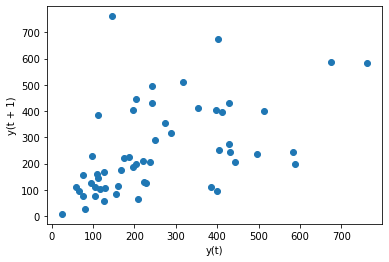

In [37]:
from pandas.plotting import lag_plot
lag_plot(y)

In [38]:
y.shape

(56,)